In [1]:
import json, re, os, nltk, itertools, urllib
from collections import Counter, defaultdict
import numpy as np
import sklearn
import timeit

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(9, 6)

In [3]:
def load_yelp_reviews(paths):
    raw_reviews = []; authors = []; dates = []; ratings = []
    json_files = [path_to_json + '/' + pos_json for path_to_json in paths for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    pattern = re.compile("\xa0")
    for js in json_files:
        with open(os.path.join(js)) as json_file:
            json_text = json.load(json_file)
            for review in json_text['Reviews']:
                #authors.append(review['Author'])
                #dates.append(review['Date'])
                content = pattern.sub('', review['Content'])
                raw_reviews.append(content)
                ratings.append(float(review['Overall']))
    #return raw_reviews, authors, dates
    return raw_reviews, ratings

In [4]:
train, ratings = load_yelp_reviews(['../data/yelp/train', '../data/yelp/test'])

# Text processing

Load tokenizer and stemmer

In [5]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

Load the stopwords and stem them

In [6]:
words = urllib.request.urlopen('http://jmlr.org/papers/volume5/lewis04a/a11-smart-stop-list/english.stop')
pattern = re.compile(r'\n')
stopwords = [pattern.sub('', word.decode("utf-8")) for word in words]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords]

In [7]:
# Tokenize
tokenized_reviews = [tokenizer.tokenize(review) for review in train]

In [8]:
# Keep only alphabetic words, thus stripping numbers and punctuactions
tokenized_reviews = [[token for split in review for token in re.findall("[a-z']+", split)] for review in tokenized_reviews]

In [9]:
# Stemming
tokenized_reviews = [[stemmer.stem(token) for token in review] for review in tokenized_reviews]

In [10]:
# Remove stopwords
tokenized_reviews = [[token for token in review if token not in stemmed_stopwords] for review in tokenized_reviews]

In [11]:
# Reprocess the ratings to obtain a binary response
labels = [1 if rating >= 4.0 else 0 for rating in ratings]

## Document frequency

In [12]:
df = Counter()
for review in tokenized_reviews:
    df.update(set(review))
print("{0} words in the vocabulary".format(len(df)))

37903 words in the vocabulary


We filter out words with a DF smaller than 5.

In [13]:
index_to_vocabulary = [w for w, freq in df.most_common() if freq > 5]
vocabulary_to_index = dict((w, i) for i, w in enumerate(index_to_vocabulary))

print('{0} words in the controlled vocabulary'.format(len(index_to_vocabulary)))

10574 words in the controlled vocabulary


In [14]:
filtered_reviews = [[w for w in review if w in index_to_vocabulary] for review in tokenized_reviews]

## Information gain

Calculate base class entropy

In [15]:
train_size = len(train)
prior = Counter(labels)
for label in prior.keys(): prior[label] = prior[label] / train_size
class_entropy = -sum([prior[v] * np.log2([prior[v]]) for v in prior.keys()])[0]

In [16]:
print('Base class entropy: {0:f}'.format(class_entropy))

Base class entropy: 0.762563


In [17]:
with open('ig_scores.txt', 'r') as f:
    ig_scores = [line.split(',') for line in f.readlines()]
ig_scores = [(a[2:-1], float(b[1:-2])) for a, b in ig_scores]

In [18]:
with open('chi2.txt', 'r') as f:
    chi2 = [line.split(',') for line in f.readlines()]
chi2 = [(a[2:-1], float(b[1:-2])) for a, b in chi2]

In [282]:
def ig(feature_set, docs, labels):
    # Calculate the entropy of a Counter object, a dictionary of (class, count) pairs,
    # with s equal to the total count. 
    def entropy(count_dict, s):
        ts = [count_dict[label]/s * np.log2(count_dict[label]/s) for label in count_dict.keys()]
        return sum(ts)
    
    # Calculate the gain from a given word
    def gain(w):
        # Calculate the entropy of the set of reviews when w is in the review
        # This entropy is multiplied by the probability of w
        w_in_set = Counter([label for label, doc in zip(labels, docs) if  in doc])
        s_in_set = sum(w_in_set.values())
        entropy_in_set = entropy(w_in_set, s_in_set) * s_in_set / N
        # Calculate the entropy of the set of reviews when w is not in the review        
        w_not_in_set = Counter([label for label, doc in zip(labels, docs) if w not in doc])
        s_not_in_set = sum(w_not_in_set.values())
        entropy_not_in_set = entropy(w_not_in_set, s_not_in_set) * s_not_in_set / N
        # The sum of class entropy and the two entropies makes the gain
        return class_entropy + entropy_in_set + entropy_not_in_set
    
    # Calculate the entropy of the corpus
    class_entropy = -entropy(Counter(labels), float(len(docs)))
    ig_scores = []
    for feature in feature_set:
        ig_scores.append((feature, gain(feature)))
    return ig_scores

In [302]:
ig_scores = ig(index_to_vocabulary, filtered_reviews, labels)

In [530]:
chi2 = []
for w in index_to_vocabulary:
    
    # Counts of labels in the set of reviews for when word is in the review
    w_in_set = Counter([label for label, doc in zip(labels, filtered_reviews) if w in doc])
    # Counts of labels in the set of reviews for when word is not in the review
    w_not_in_set = Counter([label for label, doc in zip(labels, filtered_reviews) if w not in doc])
    
    # A is the number of positive documents containing term
    A = w_in_set[1]
    # B is the number of positive documents not containing term 
    B = w_not_in_set[1]
    # C is the number of negative documents containing term
    C = w_in_set[0]
    # D is the number of negative documents not containing term.
    D = w_not_in_set[0]

    score = (A + B + C + D) * (A*D - B*C)**2 / ((A+C)*(B+D)*(A+B)*(C+D))
    chi2.append((w, score))

Filter out the chi2 square below the threshold of 3.841

In [19]:
filtered_chi2 = [(w, score) for w, score in chi2 if score >= 3.841]

In [20]:
len(filtered_chi2)

2966

2966 words kept in the chi2 scores

Top 20 words selected by information gain

In [21]:
[w for w, gain in sorted(ig_scores, key=lambda x: -x[1])[0:20]]

['bland',
 'delici',
 'mediocr',
 'perfect',
 'decent',
 'rude',
 'bad',
 'amaz',
 'disappoint',
 'terribl',
 'averag',
 'favorit',
 'worst',
 'hype',
 'overpr',
 'meh',
 'love',
 'horribl',
 'overr',
 'lack']

Top 20 words selected by chi2

In [22]:
[w for w, score in sorted(chi2, key=lambda x: -x[1])[0:20]]

['bland',
 'mediocr',
 'rude',
 'decent',
 'bad',
 'delici',
 'terribl',
 'worst',
 'averag',
 'overpr',
 'meh',
 'disappoint',
 'hype',
 'perfect',
 'amaz',
 'horribl',
 'overr',
 'lack',
 'poor',
 'favorit']

Create the control vocabulary

In [23]:
index_to_vocabulary = list(set([w for w, score in sorted(ig_scores, key=lambda x: -x[1])[0:5000]] + 
                              [w for w, score in sorted(filtered_chi2, key=lambda x: -x[1])]))

print("{0} words in the controlled vocabulary".format(len(index_to_vocabulary)))

vocabulary_to_index = dict((w, i) for i, w in enumerate(index_to_vocabulary))

5000 words in the controlled vocabulary


In [24]:
final_reviews = [[w for w in review if w in index_to_vocabulary] for review in filtered_reviews]

In [25]:
corpus = [(label, review) for label, review in zip(labels, final_reviews) if len(review) > 0]

print('{0} reviews in the final corpus after feature selection'.format(len(corpus)))

58406 reviews in the final corpus after feature selection


In [26]:
final_reviews = [review for label, review in corpus]
final_labels = [label for label, review in corpus]

## Naive Bayes

In [25]:
class Unigram(dict):
    def __init__(self, text, delta):
        self.counts = Counter(text)
        self.N = float(len(text))
        self.V = float(len(self.counts))
        self.delta = delta
        for key, count in self.counts.most_common():
            self[key] = count
    
    def __call__(self, w):
        if w in self:
            return (self[w] + self.delta) / (self.N + self.V)
        else:
            return self.delta / (self.N + self.V)

In [26]:
class NaiveBayes():
    def __init__(self, corpus, delta):
        self.positive_unigram = Unigram([token for label, review in corpus for token in review if label == 1], delta)
        self.negative_unigram = Unigram([token for label, review in corpus for token in review if label == 0], delta)
        self.delta = delta
        self.prior = Counter([label for label, review in corpus])
    
    def log_ratio(self, w):
        return np.log( self.positive_unigram(w) / self.negative_unigram(w))
    
    def score(self, doc):
        evidence = np.log(self.prior[1] / self.prior[0])
        for w in set(doc):
            evidence += np.log(self.positive_unigram(w)) - np.log(self.negative_unigram(w))
        return evidence
        
    def sign(self, doc, threshold=0):
        if self.score(doc) >= threshold:
            return 1
        else:
            return 0
        
    def plot_precision_recall_curve(self, docs, truth):
        preds = [self.score(doc) for doc in docs]
        thresholds = np.arange(min(preds), max(preds), 1)
        metrics = [self.precision_recall(preds, truth, threshold) for threshold in thresholds]
        plt.plot([x[1] for x in metrics], [x[0] for x in metrics], lw=2)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('Precision-Recall Curve, Delta = ' + str(self.delta), fontsize=20)
        plt.ylabel('Precision', fontsize=16)
        plt.xlabel('Recall', fontsize=16)
        plt.grid(True)
        plt.show()
        
    def precision_recall(self, probs, truth, threshold):
        confMat = Counter([(1, true) if prob >= threshold else (0, true) for prob, true in zip(probs, truth)])
        precision = confMat[(1, 1)] / (confMat[(1, 1)] + confMat[(1, 0)])
        recall = confMat[(1, 1)] / (confMat[(1, 1)] + confMat[(0, 1)])
        return (precision, recall)

In [27]:
bayes = NaiveBayes(corpus, 0.1)

Top 20 log ratio

In [28]:
ratios = sorted([(w, bayes.log_ratio(w)) for w in index_to_vocabulary], key = lambda x: -x[1])

In [29]:
[(w, ratio) for w, ratio in ratios[0:20]]

[('gluttoni', 4.9295249142894839),
 ('ryan', 4.9042710469682804),
 ('fantasi', 4.824441445315796),
 ('seamless', 4.6426737517317909),
 ('hoagi', 4.6426737517317909),
 ('yummo', 4.5376823078626156),
 ('boutiqu', 4.5376823078626156),
 ('scott', 4.461016426114699),
 ('lambrusco', 4.3779811975047087),
 ('devin', 4.3779811975047087),
 ('meticul', 4.3779811975047087),
 ('aldo', 4.3337261885006679),
 ('barbq', 4.3337261885006679),
 ('maxim', 4.3337261885006679),
 ('amazinggg', 4.2874216204589812),
 ('ganach', 4.2388683950419903),
 ('lobstah', 4.2388683950419903),
 ('tapioca', 4.2388683950419903),
 ('unparallel', 4.1878369150295445),
 ('iti', 4.1878369150295445)]

Get the bottom 20

In [32]:
[(w, ratio) for w, ratio in ratios[-20:]]

[('deplor', -3.1774007467355645),
 ('wade', -3.281661757059974),
 ('emperor', -3.3760714415310487),
 ('rudest', -3.5417385634198659),
 ('injuri', -3.5417385634198659),
 ('diarrhea', -3.6153011305968827),
 ('nastiest', -5.1753103771903968),
 ('flavourless', -5.1753103771903968),
 ('huf', -5.1753103771903968),
 ('dupe', -5.1753103771903968),
 ('volar', -5.1753103771903968),
 ('budg', -5.3271163900584009),
 ('insipid', -5.3271163900584009),
 ('diappoint', -5.3271163900584009),
 ('angrili', -5.3271163900584009),
 ('apathi', -5.4588856676895237),
 ('boyarde', -5.4588856676895237),
 ('reprimand', -5.4588856676895237),
 ('lipstick', -5.5752960195339352),
 ('sewer', -5.5752960195339352)]

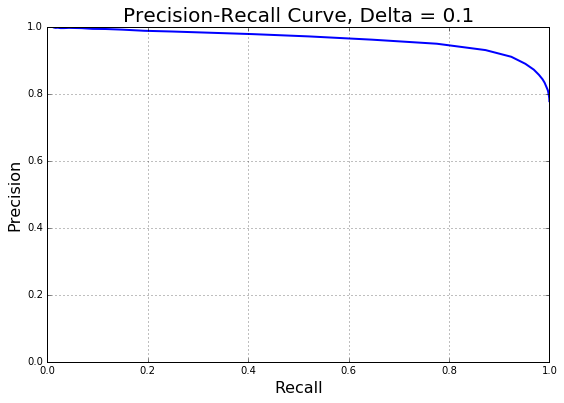

In [33]:
bayes.plot_precision_recall_curve(final_reviews, final_labels)

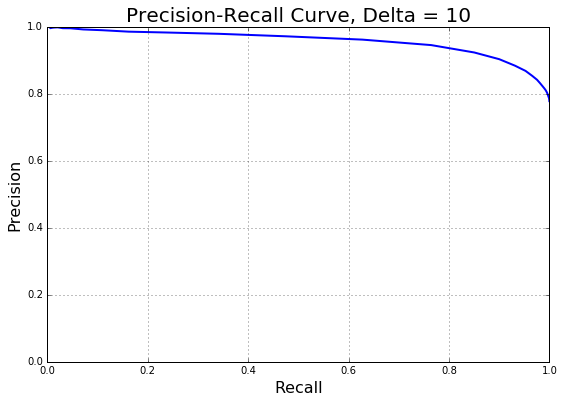

In [384]:
bayes2 = NaiveBayes(corpus, delta=10)
bayes2.plot_precision_recall_curve(final_reviews, final_labels)

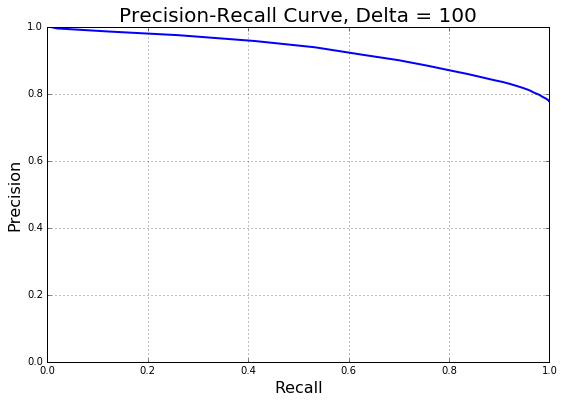

In [385]:
bayes2 = NaiveBayes(corpus, delta=100)
bayes2.plot_precision_recall_curve(final_reviews, final_labels)

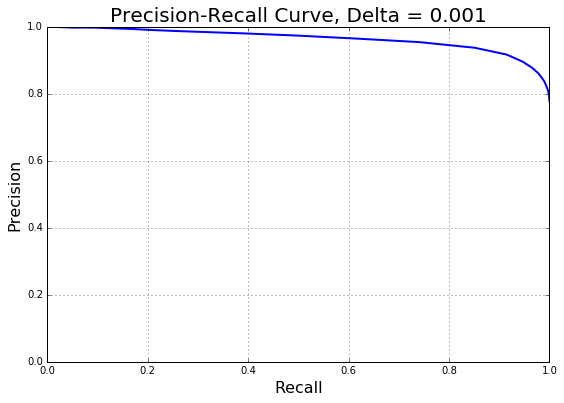

In [386]:
bayes2 = NaiveBayes(corpus, delta=0.001)
bayes2.plot_precision_recall_curve(final_reviews, final_labels)

# kNN Classifier

In [27]:
df = Counter()
for label, review in corpus:
    df.update(set(review))

In [28]:
df.most_common(10)

[('good', 26947),
 ('food', 25118),
 ('great', 21195),
 ('order', 17617),
 ('time', 17437),
 ('wait', 15840),
 ('servic', 14416),
 ('back', 14212),
 ('love', 13683),
 ('delici', 12113)]

In [29]:
M = len(index_to_vocabulary)
N = len(corpus)
print(M, N)

5000 58406


Produce the TFIDF matrix

In [30]:
tfidf = []
for label, review in corpus:
    vec = np.zeros(M)
    for w, count in Counter(review).most_common():
        vec[vocabulary_to_index[w]] = (1 + np.log(count)) * (1 + np.log(N/df[w]))
    tfidf.append(vec)

In [31]:
class kNN():
    def __init__(self, tfidf, y, lmbda):
        self.tfidf = tfidf   # Training TFIDF matrix
        self.y = y           # Training class labels
        self.m = len(tfidf[0])  # Vector length
        self.rs = [self.random_proj(self.m) for _ in range(lmbda)] # Initializing lmbda random vectors of length m
        self.lookup = [self.h(doc) for doc in tfidf]   # Creating a lookup table for the training data
        self.batches = defaultdict(list)
        for tfidf_vec, h_vec, label in zip(self.tfidf, self.lookup, self.y):
            self.batches[tuple(h_vec)].append((tfidf_vec, label))    
    
    def random_proj(self, m):
        return np.random.uniform(-1, 1, m)
    
    def h(self, x):
        return [self.sign(x.dot(r)) for r in self.rs]
    
    def sign(self, x):
        if x >= 0: return 1
        else: return 0

    def cosine(self, vec1, vec2):
        return vec1.dot(vec2) / (np.sqrt(vec1.dot(vec1)) * np.sqrt(vec2.dot(vec2)))
    
    def classify(self, x, k=5):
        neighbors = self.nearest_neighbors(x, k)
        return Counter([label for cos_sim, label in neighbors]).most_common()[0][0]
    
    def nearest_neighbors(self, x, k=5):
        r = tuple(self.h(x))
        bucket = self.batches[r]
        return sorted([(self.cosine(x, tfidf_vec), label) for tfidf_vec, label in bucket], key=lambda v: -v[0])[0:k]
    
    def bruteNN(self, x, k=5):
        return sorted([(self.cosine(x, vec), i) for i, vec in enumerate(self.tfidf)], key=lambda v: -v[0])[0:k]

In [168]:
knn = kNN(tfidf, final_labels, 2)

Evaluation

In [56]:
test, ratings = load_yelp_reviews(['../data/yelp/'])

In [57]:
tokenized_reviews = [tokenizer.tokenize(review) for review in test]
tokenized_reviews = [[token for split in review for token in re.findall("[a-z']+", split)] for review in tokenized_reviews]
tokenized_reviews = [[stemmer.stem(token) for token in review] for review in tokenized_reviews]
tokenized_reviews = [[token for token in review if token not in stemmed_stopwords] for review in tokenized_reviews]

In [169]:
%timeit knn.classify(tfidf_test[0])

1 loops, best of 3: 277 ms per loop


In [170]:
%timeit knn.classify(tfidf_test[1])

10 loops, best of 3: 173 ms per loop


In [171]:
%timeit knn.classify(tfidf_test[2])

1 loops, best of 3: 167 ms per loop


In [172]:
%timeit knn.classify(tfidf_test[3])

10 loops, best of 3: 178 ms per loop


In [173]:
%timeit knn.classify(tfidf_test[4])

1 loops, best of 3: 247 ms per loop


In [58]:
tfidf_test = []
for review in tokenized_reviews:
    vec = np.zeros(M)
    for w, count in Counter(review).most_common():
        if w in index_to_vocabulary:
            vec[vocabulary_to_index[w]] = (1 + np.log(count)) * (1 + np.log(N/df[w]))
    tfidf_test.append(vec)

In [59]:
from time import time

In [139]:
run = []
for x in tfidf_test:
    start = time()
    neighbors = knn.nearest_neighbors(x, 5)
    runtime = time() - start
    '''start = time()
    knn.bruteNN(x, 5)
    run.append((runtime, time() - start))'''
    run.append(runtime)

KeyboardInterrupt: 

In [74]:
means = np.mean(np.array(run), axis=0)
print('Runtime for random projection: {0:2f} \nRuntime for brute search: {1:2f}'.format(means[0], means[1]))

Runtime for random projection: 0.037026 
Runtime for brute search: 0.908554


In [98]:
x = tfidf_test[0]
neighbors = knn.nearest_neighbors(x, 5)
for cos_sim, neighbor in neighbors:
    print(' '.join(final_reviews[neighbor]))

tapa small plate tini joy cafe ba ba reeba version group tapa sampl drink split pitcher peach sangria good full glass spare food person bacon wrap date steak spici green pepper brais short rib mash potato dessert chocol truffl cake wrong bacon wrap date steak spici potato impress pair green pepper good tapa paella favorit paella paella brais short rib mouth succul expect chocol cake standard impress good servic plate make order impress concept tapa higher servic standard restaur plate wait show eat
star cafe babareeba delici bit commerci trendi item english fanci sangria big fan cafe iberico gave star night tapa paella sangria iberico iberico write review notic item order night back iberico order decid review heard good thing cafe babareeba time night peopl seat busi assum girl time knew order rest quick jump start pitcher white peach sangria person order black raspberri start spici potato tomato alioli chees bake tomato calamari spici potato delici chees tast bit strang good calamari 

In [560]:
test[0]

"Ahhh tapas, the small plates that contain individual tiny bites of joy. Cafe Ba-Ba-Reeba does their versions very well.In a group of 8, celebrating a birthday, many of the tapas were sampled and many drinks were to be had. Four of us split a pitcher of peach sangria, which was very good, each of us got two full glasses and there was a little top off to spare. As far as the food I personally took bites of:Bacon wrapped dates (5/5)Steak skewers (4/5)Spicy Potatotes (4/5)Fried Green Peppers (3/5) andPaella Valenciana (5/5)Braised short ribs w/mashed potatoes (5/5)Dessert - Chocolate Truffle Cake (3/5)You can't go wrong with bacon wrapped dates. The steak skewers and spicy potatoes were more impressive because of the sauce pairings. The fried green peppers were good, just not much to them, not a punch in the bite like I like my tapas. The paella was my favorite paella ever, mostly because paella usually comes with seafood and this one did not. Also it was done well. The braised short ribs

## Cross-validation

In [32]:
folds = sklearn.cross_validation.KFold(N, n_folds=10, shuffle=True)

In [33]:
X = final_reviews
y = final_labels

In [34]:
def metrics(preds, trues):
    conf = Counter([(a, b) for a, b in zip(preds, trues)])
    precision = conf[(1, 1)] / (conf[(1, 1)] + conf[(1, 0)])
    recall = conf[(1, 1)] / (conf[(1, 1)] + conf[(0, 1)])
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

In [529]:
bayes_perf = []
knn_perf = []

for train_index, test_index in folds:
    
    X_train = [X[i] for i in train_index]
    y_train = [y[i] for i in train_index]
    corpus_train = [(a, b) for a, b in zip(y_train, X_train)]
    X_test = [X[i] for i in test_index]
    y_test = [y[i] for i in test_index]
    tfidf_train = [tfidf[i] for i in train_index]
    tfidf_test = [tfidf[i] for i in test_index]
    
    bayes = NaiveBayes(corpus_train, 0.1)
    preds = [bayes.sign(doc) for doc in X_test]
    bayes_perf.append(metrics(preds, y_test))
    
    knn = kNN(tfidf_train, y_train, 5)
    preds = [knn.classify(vec) for vec in tfidf_test]
    knn_perf.append(metrics(preds, y_test))

In [568]:
with open('perfs.txt', 'w') as f:
    f.write(str(bayes_perf))
    f.write(str(knn_perf))

In [533]:
from scipy import stats

In [558]:
mean_d = np.mean(np.array(bayes_perf) - np.array(knn_perf), axis=0)
mean_se = np.std(np.array(bayes_perf) - np.array(knn_perf), axis=0) / np.sqrt(10)
ts = mean_d / mean_se
pvals = stats.t.sf(np.abs(ts), 9)*2
pvals

array([  4.59792638e-15,   1.64831808e-10,   1.08528979e-10])

## Parameter Tuning

Optimize lmbda in kNN and delta in NaiveBayes

In [128]:
folds = sklearn.cross_validation.KFold(N, n_folds=10, shuffle=True)

In [107]:
bayes_perf = []
#deltas = [0.0001]
deltas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

for train_index, test_index in folds:
    
    X_train = [X[i] for i in train_index]
    y_train = [y[i] for i in train_index]
    corpus_train = [(a, b) for a, b in zip(y_train, X_train)]
    X_test = [X[i] for i in test_index]
    y_test = [y[i] for i in test_index]
    
    for delta in deltas:
        bayes = NaiveBayes(corpus_train, delta)
        preds = [bayes.sign(doc) for doc in X_test]
        bayes_perf.append((delta, metrics(preds, y_test)))

In [99]:
lmbdas = np.random.randint(1, 10)

In [100]:
lmbdas

array([2, 7, 3, 6, 2])

In [105]:
for train_index, test_index in folds:
    print(len(train_index))

46724
46725
46725
46725
46725


In [106]:
len(tfidf)

58406

In [107]:
tfidf_train = [tfidf[i] for i in range(0, 46724)]
y_train = [y[i] for i in range(0, 46724)]
tfidf_test = [tfidf[i] for i in range(46724, 58405)]
y_test = [y[i] for i in range(46724, 58405)]

In [120]:
knn = kNN(tfidf_train, y_train, 8)

In [126]:
t = time()
preds = [knn.classify(vec) for vec in tfidf_test]
print(time() - t)

36.79567527770996


In [127]:
metrics(preds, y_test)

(0.8066679083628236, 0.9501974550241334, 0.87256975924247)

In [129]:
knn_perf = []
lmbdas = [2, 4, 6, 8, 10]
j = 0

for train_index, test_index in folds:
    
    tfidf_train = [tfidf[i] for i in train_index]
    y_train = [y[i] for i in train_index]
    tfidf_test = [tfidf[i] for i in test_index]
    y_test = [y[i] for i in test_index]
    
    for lmbda in lmbdas:
        knn = kNN(tfidf_train, y_train, lmbda)
        preds = [knn.classify(vec) for vec in tfidf_test]
        knn_perf.append((lmbda, metrics(preds, y_test)))
        print(j, lmbda)
    j += 1

0 2
0 5
0 8
1 2
1 5
1 8
2 2
2 5
2 8
3 2
3 5
3 8
4 2
4 5
4 8
5 2
5 5
5 8
6 2
6 5
6 8
7 2
7 5
7 8
8 2
8 5
8 8
9 2
9 5
9 8


In [36]:
knn = kNN(tfidf, y, 5)

In [39]:
knn.classify(tfidf[0], 7)

1

In [ ]:
knn_perf = []

In [47]:
ks = [11, 19]
j = 0

for train_index, test_index in folds:
    
    tfidf_train = [tfidf[i] for i in train_index]
    y_train = [y[i] for i in train_index]
    tfidf_test = [tfidf[i] for i in test_index]
    y_test = [y[i] for i in test_index]
    knn = kNN(tfidf_train, y_train, 5)
    
    for k in ks:
        print(j, k)
        preds = [knn.classify(vec, k) for vec in tfidf_test]
        knn_perf.append((k, metrics(preds, y_test)))
    j += 1

0 11
0 19
1 11
1 19
2 11
2 19
3 11
3 19
4 11
4 19
5 11
5 19
6 11
6 19
7 11
7 19
8 11
8 19
9 11
9 19


In [51]:
[f1 for k, (precision, recall, f1) in knn_perf]

[0.8677054689886954,
 0.8759387203364375,
 0.8769383697813121,
 0.8758090614886731,
 0.8852165256346441,
 0.8861009582139683,
 0.8673417203641199,
 0.8781074578989574,
 0.8823938761308282,
 0.8736713000817662,
 0.8795653486266224,
 0.8811397828036267,
 0.8740755749164218,
 0.8825580237075406,
 0.8837301195297836,
 0.8769324654190399,
 0.8857683497659596,
 0.8868259924945685,
 0.8662122291179164,
 0.8773263958375025,
 0.8815607050901169,
 0.8681901652723933,
 0.8782739588559959,
 0.8783110934076878,
 0.8686702346644709,
 0.8767676767676769,
 0.8781024819855885,
 0.8721512519161984,
 0.88012904526666,
 0.8806863527533919,
 0.8765371372356123,
 0.8772820462755052,
 0.8848674557370634,
 0.8846564959673502,
 0.8813426243988616,
 0.8808643176951528,
 0.8841235490851858,
 0.883394977613393,
 0.888540953126529,
 0.887527947895402,
 0.8871062414400313,
 0.8864077669902912,
 0.8845439436895103,
 0.8848920863309353,
 0.8779767762251526,
 0.8783347991791264,
 0.8778851844545276,
 0.876224050137093